In [1]:
import torch.nn as nn
import numpy as np
import networkx as nx


/home/shyam/anaconda3/envs/pytorch_geometric/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


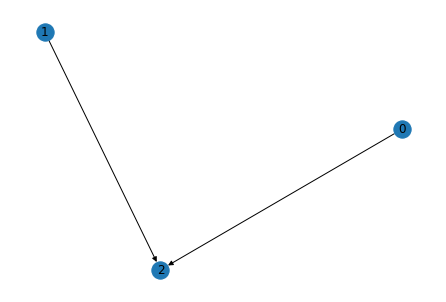

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph, GCNConv, max_pool_neighbor_x, radius_graph, knn
import torch_geometric
import matplotlib

edge_index = torch.tensor([[0, 2],
                           [1, 2],
                           ], dtype=torch.long)
# x = torch.tensor([[-15, 1], [0, 1], [30, 1], [0,2]], dtype=torch.float)
x = torch.randn((3, 21))
data = Data(x=x, edge_index=edge_index.t())
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g, with_labels=True)

In [3]:
x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
batch_x = torch.tensor([0, 0, 0, 0])
y = torch.Tensor([[-1, 0], [1, 0]])
batch_x = torch.tensor([0, 0])
assign_index = knn(x, y, 1)

In [4]:
assign_index

tensor([[0, 1],
        [0, 2]])

In [5]:
data.edge_index

tensor([[0, 1],
        [2, 2]])

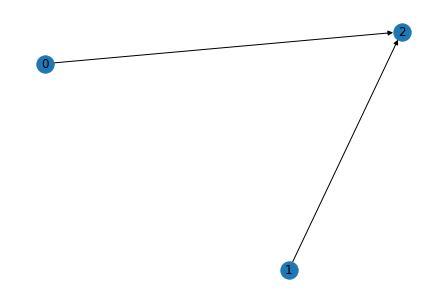

In [6]:
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g, with_labels=True)

In [7]:
data.edge_index

tensor([[0, 1],
        [2, 2]])

In [8]:
x[np.where(x[:, 0] > 0)[0]]

tensor([[ 1., -1.],
        [ 1.,  1.]])

In [9]:
torch.vstack((torch.zeros((3,32)), torch.ones((1,32)))).size()

torch.Size([4, 32])

In [227]:
class DirectedGraph:
    def __init__(self, nodes, edge_dict, num_input_nodes, num_output_nodes):
        self.num_input_nodes = num_input_nodes
        self.num_output_nodes = num_output_nodes
        self.nodes = nodes
        self.edge_dict = edge_dict

    def add_edges(self, new_edges):
        for node in new_edges:
            if node not in self.edge_dict:
                self.edge_dict[node] = []
            destinations = new_edges[node]
            for d in destinations:
                if d not in self.edge_dict[node]:
                    self.edge_dict[node].append(d)

    def add_nodes(self, nodes):
        self.nodes = torch.vstack((self.nodes, nodes))

    def to_data(self):
        edges = []

        for node in self.edge_dict:
            destinations = self.edge_dict[node]
            for d in destinations:
                edges.append([node, d])
        
        edges = torch.tensor(edges).long().t().contiguous()
        return Data(x=self.nodes, edge_index=edges)


    # A recursive function used by topologicalSort
    def topologicalSortUtil(self, v, visited, stack):
 
        # Mark the current node as visited.
        visited[v] = True
 
        # Recur for all the vertices adjacent to this vertex
        if v in self.edge_dict:
            for i in self.edge_dict[v]:
                if visited[i] == False:
                    self.topologicalSortUtil(i, visited, stack)

        # Push current vertex to stack which stores result
        stack.append(v)
 
    # The function to do Topological Sort. It uses recursive
    # topologicalSortUtil()
    def topological_sort(self):
        # Mark all the vertices as not visited
        self.V = self.nodes.size(0)
        visited = [False]*self.V
        stack = []
 
        # Call the recursive helper function to store Topological
        # Sort starting from all vertices one by one
        for i in range(self.V):
            if visited[i] == False:
                self.topologicalSortUtil(i, visited, stack)
 
        # Print contents of the stack
        return stack[::-1]

    def plot(self):
        data = self.to_data()
        G = torch_geometric.utils.to_networkx(data, to_undirected=False)

        pos=nx.drawing.nx_agraph.graphviz_layout(
            G,
            prog='dot',
            args='-Grankdir=LR'
        )

        fig = plt.figure()
        canvas = FigureCanvas(fig)

        nodes = nx.draw_networkx_nodes(G,pos)
        edges = nx.draw_networkx_edges(G,pos)
        nx.draw_networkx_labels(G, pos)

        canvas.draw()       # draw the canvas, cache the renderer

        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        return image

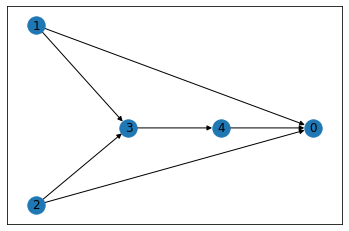

In [229]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph, GCNConv, max_pool_neighbor_x, radius_graph
import torch_geometric
import matplotlib
from torch_geometric.utils import get_num_hops, coalesce, k_hop_subgraph

x = torch.zeros((5, 2))
x[3,0] = 4
x[1,0] = 2

edge_dict = {1:[0, 3], 2:[0, 3], 4:[0], 3:[4]}
graph = DirectedGraph(x[:, 0:1], edge_dict, 2, 1)
img = graph.plot()

In [230]:
class GraphNCA(nn.Module):
    def __init__(
        self,
        graph,
        num_operations: int = 3,
        num_hidden_channels: int = 16,
        num_neighbors: int = 2,
    ):
        super().__init__()
        self.graph = graph

        self.value_idx = 0
        self.replication_idx = 1

        self.replicated_cells = []
        self.num_operations = num_operations
        self.num_hidden_channels = num_hidden_channels
        self.num_neighbors = num_neighbors
        self.num_channels = num_operations + num_hidden_channels + 1 + 1
        
        self.perception_net = GCNConv(self.num_channels, self.num_channels*3, bias=False)
        self.update_net = nn.Sequential(
            nn.Linear(self.num_channels*3, 32),
            nn.ReLU(),
            nn.Linear(32, self.num_channels)
        )
        self.replication_network = nn.Linear(self.num_channels, self.num_channels)

    def forward(self, x, edge_index):
        features = self.perception_net(x, edge_index)
        update = self.update_net(features)
        x = x + update
        return x, edge_index

    def replicate(self, x, edge_dict, replication_threshold: float = 0.5):
        num_nodes = x.shape[0]
        current_count = num_nodes

        ready_to_replicate = x[:, 1] > replication_threshold
        ready_to_replicate = ready_to_replicate.squeeze().detach().cpu().numpy()
        ready_to_replicate_indices = [i for i in range(len(ready_to_replicate)) if ready_to_replicate[i]]
        if len(ready_to_replicate_indices) > 0:
            if ready_to_replicate_indices[0] == 0:
                ready_to_replicate_indices = ready_to_replicate_indices[1:]

            children = self.replication_network(x[ready_to_replicate_indices])

            new_edge_dict = {}
            for parent_node in ready_to_replicate_indices:
                parent_destinations = edge_dict[parent_node]
                random_destination = random.choices(parent_destinations, k=1)
                new_edge_dict[current_count] = random_destination # set child node to new destination
                new_edge_dict[parent_node] = [current_count] # add edge to parent node
                current_count += 1

            return children, new_edge_dict
        return None, None

    def add_to_graph(self, children, new_edge_dict):
        self.graph.add_nodes(children)
        self.graph.add_edges(new_edge_dict)


In [180]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class NCAGCNConv(MessagePassing):
    def __init__(self, graph, in_channels, out_channels, aggr="add", norm=False):
        super().__init__(aggr=aggr)  # "Add" aggregation (Step 5).
        self.graph = graph
        self.norm = norm
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.value_channel = 0
        self.operation_channels = [1, 3]
        self.activation_channels = [4, 5]

        self.topological_order = self.graph.topological_sort()
        self.operations = [torch.add, torch.subtract, torch.multiply]
        self.activations = [torch.relu, torch.tanh]

    def forward(self, x, edge_index):
        # Step 4-5: Start propagating messages.
        out = torch.ones(x[:, self.value_channel:self.value_channel+1].size())*x[:, self.value_channel:self.value_channel+1]
        for node in self.topological_order[self.graph.num_input_nodes:]:
            operation_logits = x[node, self.operation_channels[0]:self.operation_channels[1]]
            activation_logits = x[node, self.activation_channels[0]:self.activation_channels[1]]

            operations_dist = td.categorical.Categorical(logits=operation_logits)
            activations_dist = td.categorical.Categorical(logits=activation_logits)

            sampled_operations = operations_dist.sample().squeeze()
            sampled_activations = activations_dist.sample().squeeze()
            operation = self.operations[sampled_operations]
            activation = self.activations[sampled_activations]

            node_ids, edges, _, _ = k_hop_subgraph(node, 1, edge_index)

            node_propagate = self.propagate(edges, x=out, operation=operation, activation=activation)
            out[node] = out[node] + node_propagate[node] - out[node]
        return out

    def message(self, x_i, x_j, operation, activation):
        # x_j has shape [E, out_channels]
        out = operation(x_i, x_j)
        return activation(out)

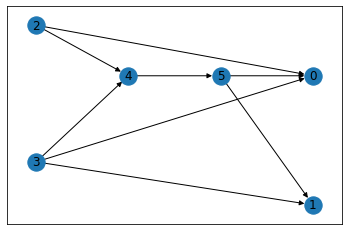

In [234]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph, GCNConv, max_pool_neighbor_x, radius_graph
import torch_geometric
import matplotlib.pyplot as plt
from torch_geometric.utils import get_num_hops, coalesce, k_hop_subgraph
import io
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
x = torch.ones((6, 6))
x[4,0] = 4
x[2,0] = 2

edge_dict = {2:[0, 4], 3:[0, 1, 4], 4:[5], 5:[0, 1], 0:[], 1:[]}
graph = DirectedGraph(x, edge_dict, 2, 1)
data = graph.to_data()
image = graph.plot()
# io_buf = io.BytesIO()
# fig.savefig(io_buf, format='raw', dpi=128)
# io_buf.seek(0)
# img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
#                      newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
# io_buf.close()


In [235]:
x = identity_conv(data.x, data.edge_index)
x

tensor([[ 0.],
        [ 0.],
        [ 2.],
        [ 1.],
        [11.],
        [12.]])

In [705]:
x = identity_conv(x, data.edge_index)
x

tensor([[25.],
        [ 0.],
        [ 0.],
        [ 0.],
        [11.],
        [ 3.]])

In [616]:
x

tensor([[25.],
        [ 0.],
        [ 0.],
        [ 0.],
        [11.],
        [ 3.]])

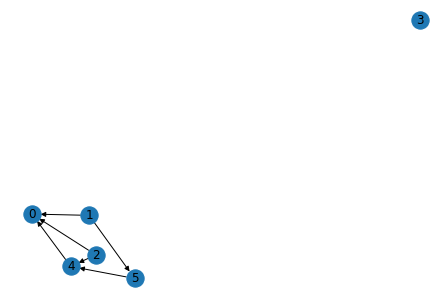

In [185]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph, GCNConv, max_pool_neighbor_x, radius_graph
import torch_geometric
import matplotlib

x = torch.ones((6, 21))
x[0,1] = 1
x[1,1] = 2

edge_dict = {1:[0, 5], 2:[0, 4], 4:[0], 5:[4]}
graph = DirectedGraph(x[:, 0:1], edge_dict, 2, 1)
data = graph.to_data()
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
_ = nx.draw(g, with_labels=True)

In [714]:
nca = GraphNCA(graph, 3, 16, 2)
nca.num_channels

21

In [715]:
for i in range(5):
    data = nca.graph.to_data()
    next_x, edge_index  = nca(data.x, data.edge_index)
    nca.graph.nodes = next_x

    children, new_edges = nca.replicate(next_x, graph.edge_dict)
    nca.add_to_graph(children, new_edges)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x1 and 21x63)

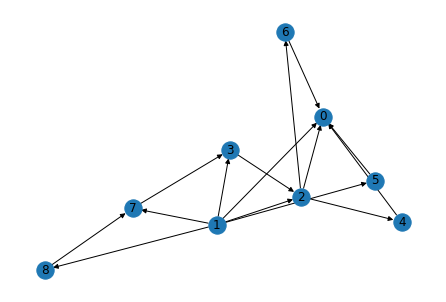

In [296]:
data = nca.graph.to_data()
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
pos = nx.spring_layout(g, seed = 0)
nx.draw(g, pos=pos,with_labels=True)

In [299]:
identity_conv = IdentityGCNConv(2, 2)

In [303]:
data.x

tensor([[ 2.4437e+00, -1.3570e+00, -1.7705e+00, -3.8046e-01,  1.5004e+00,
          1.1859e+00, -5.5154e-01, -5.1324e-01,  1.6691e+00, -1.0229e+00,
         -6.6746e-01, -1.6577e-01, -4.9319e-01,  8.6782e-01,  8.1268e-01,
         -2.2976e+00, -2.0992e-03, -7.5857e-01,  2.4150e+00,  1.5320e+00,
          1.1335e+00],
        [ 9.6187e-01,  1.3861e+00, -1.7573e-01, -8.3022e-01, -4.2061e-01,
         -1.3385e+00,  3.0175e-01, -6.0508e-01,  2.3885e+00, -4.3559e-01,
          6.0779e-01,  8.7722e-01, -1.3140e+00, -1.7622e-01,  6.1953e-01,
          8.4663e-02, -2.0124e-02, -1.0324e+00,  1.2065e+00,  2.5444e-01,
         -3.7407e-01],
        [ 9.2642e-02,  3.9581e-01, -6.6510e-01, -8.4826e-01,  6.5276e-01,
          9.7309e-01, -1.8162e+00, -1.3412e+00,  8.6979e-01,  1.0230e+00,
         -2.9033e-01, -3.2902e-01, -4.9323e-01,  8.7803e-01,  2.8098e-01,
         -6.3776e-01, -4.7226e-01,  1.6691e-01,  9.3597e-01, -1.5739e-01,
         -4.7627e-01],
        [ 9.2151e-02,  3.3150e-01, -4.1434e

In [302]:
identity_conv(data.x, data.edge_index)

tensor([[ 1.1703e+00,  4.0100e-01, -1.2123e+00, -1.1024e+00,  6.6422e-01,
          3.8248e-01, -1.0485e+00, -8.1578e-01,  1.7262e+00, -5.4060e-02,
         -4.9698e-02,  8.2744e-02, -6.4307e-01,  4.4837e-01,  5.4991e-01,
         -8.2710e-01, -4.8947e-01, -4.7159e-01,  1.3711e+00, -5.9254e-02,
         -2.2754e-01],
        [ 9.6187e-01,  1.3861e+00, -1.7573e-01, -8.3022e-01, -4.2061e-01,
         -1.3385e+00,  3.0175e-01, -6.0508e-01,  2.3885e+00, -4.3559e-01,
          6.0779e-01,  8.7722e-01, -1.3140e+00, -1.7622e-01,  6.1953e-01,
          8.4663e-02, -2.0124e-02, -1.0324e+00,  1.2065e+00,  2.5444e-01,
         -3.7407e-01],
        [ 6.1693e-01,  1.0427e+00, -4.6127e-01, -1.0774e+00,  1.9614e-01,
         -1.3588e-01, -9.8947e-01, -1.1212e+00,  1.8129e+00,  3.9094e-01,
          1.7052e-01,  2.7483e-01, -1.0424e+00,  4.1510e-01,  5.5336e-01,
         -3.5288e-01, -2.4683e-01, -5.3493e-01,  1.2147e+00,  6.0125e-02,
         -4.7762e-01],
        [ 5.4716e-01,  9.9955e-01, -2.4138e

In [277]:
nca.graph.edge_dict

{2: [0, 3, 4, 6, 10, 17],
 1: [0],
 3: [0, 5, 7, 11, 18],
 4: [3, 8, 12, 19],
 5: [0, 9, 13, 20],
 6: [0, 14, 21],
 7: [5, 15, 22],
 8: [3, 16, 23],
 9: [0],
 10: [3, 24],
 11: [5, 25],
 12: [8, 26],
 13: [0],
 14: [0, 27],
 15: [5],
 16: [3],
 17: [0],
 18: [5],
 19: [12],
 20: [9],
 21: [14],
 22: [5],
 23: [3],
 24: [3],
 25: [5],
 26: [8],
 27: [0]}

In [24]:
children, ready_to_replicate_indices, newer_edges = nca.replicate(new_x, new_edges)
new_x, new_edges = nca.add_to_graph(new_x, newer_edges, children, new_edges)

[array([0, 3])]


ValueError: can only convert an array of size 1 to a Python scalar

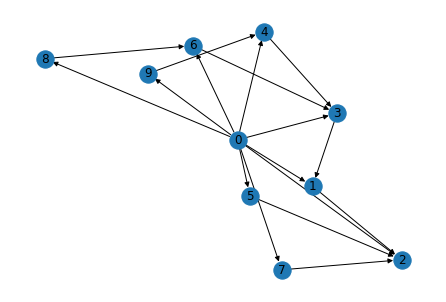

In [19]:
data = Data(x=new_x, edge_index=new_edges)
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g, with_labels=True)

In [501]:
ready_to_replicate_indices

[array([0])]

In [502]:
data.edge_index[data.edge_index[0,:] == 0].squeeze()

IndexError: The shape of the mask [3] at index 0 does not match the shape of the indexed tensor [2, 3] at index 0

In [268]:
children[-1][0].size()

torch.Size([2])

In [274]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1],
                           [1, 2]], dtype=torch.long)
x = torch.randn((3, 21)).float()

data = Data(x=x, edge_index=edge_index.t())

x

tensor([[-2.1518, -0.0545, -0.4852,  0.2450, -0.1192,  0.4385,  0.6099, -0.1925,
         -0.3980, -0.6009, -1.3360,  0.9667, -0.4163, -1.3170, -0.8413, -0.8533,
          0.8909, -0.4733,  0.8833, -0.1676,  1.3862],
        [ 0.4133,  0.1275,  0.7016, -0.9798,  0.1912, -0.4921,  1.5015,  0.8841,
          1.3806, -0.6102, -0.6511, -0.0560, -0.0845,  0.4691,  0.4130,  0.9796,
         -0.4284,  0.5231, -0.6941, -0.1628, -0.7780],
        [ 0.0116, -0.0766, -1.2932,  1.8178, -0.3601, -1.4202,  0.6789, -0.6835,
         -0.9408,  0.5244, -1.5726, -0.5691,  1.2863, -0.8838,  0.5926,  0.6874,
          0.4350,  0.4006, -0.2375,  0.4477,  0.3360]])

In [275]:
x, edge_index = nca(data.x, data.edge_index)

In [276]:
x

tensor([[-2.1648, -0.0239, -0.4403,  0.0034, -0.1449,  0.4023,  0.9204, -0.3241,
         -0.1292, -0.7066, -1.3487,  1.4323, -0.4892, -1.3658, -0.8887, -0.6354,
          0.7959, -0.4894,  0.7223,  0.0094,  1.6363],
        [ 0.3408,  0.2361,  0.7076, -1.1064,  0.1664, -0.5869,  1.7929,  0.6625,
          1.6902, -0.7012, -0.6915,  0.2530, -0.0683,  0.3550,  0.3001,  1.1454,
         -0.5667,  0.4875, -0.7918,  0.0720, -0.5668],
        [-0.0047, -0.0438, -1.1874,  1.7672, -0.4022, -1.3480,  0.8275, -0.8784,
         -0.8981,  0.4702, -1.5520, -0.4244,  1.2870, -0.9447,  0.4383,  0.7652,
          0.3059,  0.5264, -0.3326,  0.6082,  0.4845]], grad_fn=<AddBackward0>)

In [70]:
from torch_geometric.nn import knn_graph, GCNConv, max_pool_neighbor_x, radius_graph

In [63]:
import torch
from torch_geometric.nn import knn

x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
y = torch.Tensor([[-1, 0], [1, 0]])
assign_index = knn(x, x, 2)

In [64]:
x.size()

torch.Size([4, 2])

In [65]:
assign_index

tensor([[0, 0, 1, 1, 2, 2, 3, 3],
        [0, 1, 1, 0, 2, 0, 3, 1]])

In [54]:
max_pool_neighbor_x(data)

Data(x=[3, 2], edge_index=[2, 2])

In [38]:
conv = GCNConv(-1,2)

In [39]:
conv(x, data.edge_index)

tensor([[ 13.0319,   5.8304],
        [  8.9460,   4.0228],
        [-14.1074,  -6.2298]], grad_fn=<AddBackward0>)

In [67]:
knn_graph(x, 2)

tensor([[1, 2, 0, 3, 0, 3, 1, 2],
        [0, 0, 1, 1, 2, 2, 3, 3]])

In [42]:
x.size()

torch.Size([3, 2])

In [45]:
conv(x,data.edge_index)

tensor([[ 13.0319,   5.8304],
        [  8.9460,   4.0228],
        [-14.1074,  -6.2298]], grad_fn=<AddBackward0>)